# Machine Learning Risk Prediction Analysis

This notebook demonstrates machine learning approaches for vulnerability risk prediction and asset prioritization.

**NEW:** Integrates scenario-specific configurations for comparative analysis across enterprise, government, and small business environments.

In [20]:
# Import required libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Import configuration utilities
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from utils.util import load_config

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [21]:
# Configuration and Scenario Management

# Import configuration utilities
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from utils.util import load_config

def load_scenario_config(scenario_name):
    """Load scenario-specific configuration and merge with default config."""
    # Get the base directory (SynthVuln root)
    base_dir = os.path.dirname(os.getcwd()) if os.path.basename(os.getcwd()) == 'evaluations' else os.getcwd()
    
    # Load default configuration
    default_config_path = os.path.join(base_dir, 'configs', 'generator_config.yaml')
    default_config = load_config(default_config_path, use_fallback=True)
    
    # Load scenario-specific configuration
    scenario_config_path = os.path.join(base_dir, 'configs', f'scenario_{scenario_name}.yaml')
    scenario_config = load_config(scenario_config_path, use_fallback=True)
    
    # Debug: Print paths and check if configs loaded
    print(f"Default config path: {default_config_path}")
    print(f"Scenario config path: {scenario_config_path}")
    print(f"Default config loaded: {default_config is not None}")
    print(f"Scenario config loaded: {scenario_config is not None}")
    
    # Handle case where configs might be None
    if default_config is None:
        default_config = {}
    if scenario_config is None:
        scenario_config = {}
    
    # Merge configurations (scenario-specific overrides default)
    merged_config = {**default_config, **scenario_config}
    
    return merged_config

# Set scenario for analysis (change this to analyze different scenarios)
SCENARIO = 'enterprise'  # Options: 'enterprise', 'government', 'small'

# Load scenario configuration
config = load_scenario_config(SCENARIO)

print(f"Analyzing {SCENARIO.upper()} scenario")
print(f"Configuration loaded: {len(config.get('asset_types', []))} asset types, {len(config.get('locations', []))} locations")
print(f"Asset types: {', '.join(config.get('asset_types', []))}")

Default config path: c:\Users\Logan\projects\agentic-vulnerability-analysis\utils\SynthVuln\configs\generator_config.yaml
Scenario config path: c:\Users\Logan\projects\agentic-vulnerability-analysis\utils\SynthVuln\configs\scenario_enterprise.yaml
Default config loaded: True
Scenario config loaded: False
Analyzing ENTERPRISE scenario
Configuration loaded: 24 asset types, 4 locations
Asset types: Desktop, Laptop, Mobile device, Workstation, Server, Webserver, Storage server, Virtualization server, Virtual machine, Container, Kubernetes cluster, Serverless, Database server, Application server, Mail server, Firewall, Load balancer, Router, Switch, Proxy server, DNS server, DHCP server, Identity server, VPN server


## Data Loading and Preparation

In [22]:
# Import required libraries for this cell
import json
import pandas as pd

def load_scenario_data(scenario_name):
    """Load vulnerability data for a specific scenario"""
    # Load assets
    assets_file = f'../data/outputs/scenario_{scenario_name}_assets.json'
    with open(assets_file, 'r') as f:
        assets = json.load(f)
    
    # Load findings
    findings_file = f'../data/outputs/scenario_{scenario_name}_findings.json'
    with open(findings_file, 'r') as f:
        findings = json.load(f)
    
    return assets, findings

def load_all_scenarios():
    """Load data for all scenarios for comparative analysis"""
    scenarios = ['enterprise', 'government', 'small']
    all_data = {}
    
    for scenario in scenarios:
        try:
            assets, findings = load_scenario_data(scenario)
            all_data[scenario] = {'assets': assets, 'findings': findings}
            print(f"Loaded {scenario}: {len(assets)} assets, {len(findings)} findings")
        except FileNotFoundError:
            print(f"Warning: Data files not found for {scenario} scenario")
    
    return all_data

def prepare_features(assets, findings):
    """Prepare features for ML model"""
    # Convert assets to DataFrame
    assets_df = pd.DataFrame(assets)
    
    # Convert findings to DataFrame and aggregate by asset
    findings_df = pd.DataFrame(findings)
    
    # Calculate vulnerability metrics per asset
    vuln_metrics = findings_df.groupby('asset_uuid').agg({
        'base_score': ['count', 'mean', 'max', 'std'],
        'severity': [
            lambda x: (x == 'CRITICAL').sum(),
            lambda x: (x == 'HIGH').sum(),
            lambda x: (x == 'MEDIUM').sum(),
            lambda x: (x == 'LOW').sum()
        ],
        'cve_id': 'nunique'
    }).round(2)
    
    # Flatten column names
    vuln_metrics.columns = ['vuln_count', 'avg_cvss', 'max_cvss', 'cvss_std', 'critical_count', 'high_count', 'medium_count', 'low_count', 'unique_cves']
    vuln_metrics['cvss_std'] = vuln_metrics['cvss_std'].fillna(0)
    
    # Merge with assets
    assets_df = assets_df.merge(vuln_metrics, left_on='uuid', right_index=True, how='left')
    
    # Fill NaN values for assets without vulnerabilities
    vuln_cols = ['vuln_count', 'avg_cvss', 'max_cvss', 'cvss_std', 'critical_count', 'high_count', 'medium_count', 'low_count', 'unique_cves']
    assets_df[vuln_cols] = assets_df[vuln_cols].fillna(0)
    
    return assets_df

# Load and prepare data for current scenario
assets, findings = load_scenario_data(SCENARIO)
df = prepare_features(assets, findings)

print(f"Loaded {len(assets)} assets and {len(findings)} findings for {SCENARIO} scenario")
print(f"Dataset shape: {df.shape}")
df.head()

Loaded 1000 assets and 20000 findings for enterprise scenario
Dataset shape: (1000, 27)


,uuid,domain_name,hostname,user_accounts,privileged_user_accounts,type,os_family,os_version,lifecycle_stage,internet_exposed,public_ip,internal_ip,open_ports,endpoint_security_installed,local_firewall_active,location,cloud_provider,installed_software,vuln_count,avg_cvss,max_cvss,cvss_std,critical_count,high_count,medium_count,low_count,unique_cves
0,0c5d532a-d919-48b5-856a-ea2faf130c79,domain3.local,internal-server-8748,"[user1, user2, user3, user4, user5]","[admin1, admin2, admin3, admin4, admin5]",Server,Windows Server 2019,Windows Server 2019 Generic,Production,False,None,192.168.10.16,"[8443, 443, 8080]",True,False,Internal,None,[{'name': 'Businessobjects Crystal Reports Ser...,21,6.98,9.8,1.38,2,8,11,0,21
1,93d29e0c-2220-458b-b9be-dc0e30820bcb,domain2.local,remote-laptop-6449,"[user1, user2]","[admin1, admin2]",Laptop,macOS,macOS Big Sur,Production,False,None,192.168.1.145,"[3389, 22]",True,True,Remote,None,"[{'name': 'Apple Itunes', 'version': '5.8.5', ...",11,6.23,9.8,2.80,2,2,5,1,11
2,f359d6d9-ac53-43a0-9217-dbba8576935f,domain3.local,remote-desktop-5993,"[user1, user2, user3, user4]",[admin1],Desktop,macOS,macOS Ventura,Decommissioned,False,None,10.0.1.32,"[3389, 22]",True,True,Remote,None,"[{'name': 'Ibm Lotus Notes Client', 'version':...",20,6.97,9.9,2.06,4,7,8,1,20
3,9199b0e8-ea68-4397-9790-2884a777f50a,domain5.local,data-center-kubernetes-cluster-2689,"[user1, user2, user3, user4, user5, user6, use...",[admin1],Kubernetes cluster,Red Hat Enterprise Linux 8,Red Hat Enterprise Linux 8 Generic,Production,False,None,10.10.0.184,"[8080, 6443, 10250]",False,False,Data center,None,[{'name': 'Businessobjects Crystal Reports Ser...,14,6.79,9.8,2.55,2,5,6,0,14
4,4e581d1f-b9ae-4556-ab48-791e7ef0b770,domain1.local,internal-laptop-1503,"[user1, user2, user3, user4, user5, user6, use...","[admin1, admin2, admin3, admin4]",Laptop,macOS,macOS Big Sur,Production,False,None,192.168.10.168,"[3389, 5900]",False,True,Internal,None,"[{'name': 'Apple Safari', 'version': '11.0.3',...",29,6.47,9.8,2.08,2,11,12,4,29


## Enhanced Feature Set

This notebook now includes enhanced features for improved risk prediction modeling:

### Asset Security Attributes:
- **endpoint_security_installed**: Whether endpoint security software is installed
- **local_firewall_active**: Whether local firewall is active
- **privileged_user_accounts**: Count of privileged user accounts

### Risk Count Features:
- **critical_count**: Number of critical severity vulnerabilities
- **high_count**: Number of high severity vulnerabilities
- **medium_count**: Number of medium severity vulnerabilities
- **low_count**: Number of low severity vulnerabilities

These features are integrated into the risk scoring algorithm, where security controls act as risk reduction factors.

## Feature Engineering

In [23]:
# Import required preprocessing tools for this cell
from sklearn.preprocessing import LabelEncoder

def engineer_features(df):
    """Engineer features for ML model"""
    # Create a copy to avoid modifying original
    df_ml = df.copy()
    
    # Encode categorical variables
    label_encoders = {}
    categorical_cols = ['asset_type', 'operating_system', 'lifecycle_stage', 'location']
    
    for col in categorical_cols:
        if col in df_ml.columns:
            le = LabelEncoder()
            df_ml[f'{col}_encoded'] = le.fit_transform(df_ml[col].astype(str))
            label_encoders[col] = le
    
    # Create binary features
    df_ml['is_internet_exposed'] = df_ml['internet_exposed'].astype(int)
    df_ml['has_vulnerabilities'] = (df_ml['vuln_count'] > 0).astype(int)
    
    # Add security-related binary features
    if 'endpoint_security_installed' in df_ml.columns:
        df_ml['has_endpoint_security'] = df_ml['endpoint_security_installed'].astype(int)
    if 'local_firewall_active' in df_ml.columns:
        df_ml['has_local_firewall'] = df_ml['local_firewall_active'].astype(int)
    
    # Create privileged user count feature
    if 'privileged_user_accounts' in df_ml.columns:
        df_ml['privileged_user_count'] = df_ml['privileged_user_accounts'].apply(
            lambda x: len(x) if isinstance(x, list) else 0
        )
    
    # Create enhanced risk score as target variable (composite of multiple factors)
    risk_components = [
        df_ml['avg_cvss'] * 0.3,
        df_ml['critical_count'] * 2.0,
        df_ml['high_count'] * 1.0,
        df_ml['medium_count'] * 0.5,
        df_ml['vuln_count'] * 0.1,
        df_ml['is_internet_exposed'] * 1.5
    ]
    
    # Add security controls as risk reduction factors
    if 'has_endpoint_security' in df_ml.columns:
        risk_components.append(-df_ml['has_endpoint_security'] * 0.5)
    if 'has_local_firewall' in df_ml.columns:
        risk_components.append(-df_ml['has_local_firewall'] * 0.3)
    if 'privileged_user_count' in df_ml.columns:
        risk_components.append(df_ml['privileged_user_count'] * 0.2)
    
    df_ml['risk_score'] = sum(risk_components)
    # Ensure risk score is non-negative
    df_ml['risk_score'] = df_ml['risk_score'].clip(lower=0)
    
    # Select features for modeling
    feature_cols = [
        'asset_type_encoded', 'operating_system_encoded', 'lifecycle_stage_encoded',
        'location_encoded', 'is_internet_exposed', 'vuln_count', 'avg_cvss',
        'max_cvss', 'cvss_std', 'critical_count', 'high_count', 'medium_count',
        'low_count', 'unique_cves', 'has_endpoint_security', 'has_local_firewall',
        'privileged_user_count'
    ]
    
    # Filter to only include columns that exist
    feature_cols = [col for col in feature_cols if col in df_ml.columns]
    
    return df_ml, feature_cols, label_encoders

df_ml, feature_cols, label_encoders = engineer_features(df)

print(f"Features for modeling: {feature_cols}")
print(f"Risk score statistics:")
print(df_ml['risk_score'].describe())

Features for modeling: ['lifecycle_stage_encoded', 'location_encoded', 'is_internet_exposed', 'vuln_count', 'avg_cvss', 'max_cvss', 'cvss_std', 'critical_count', 'high_count', 'medium_count', 'low_count', 'unique_cves', 'has_endpoint_security', 'has_local_firewall', 'privileged_user_count']
Risk score statistics:
count    1000.000000
mean       20.339234
std         4.639038
min         8.641000
25%        17.137000
50%        20.217500
75%        23.697250
max        33.627000
Name: risk_score, dtype: float64


## Exploratory Data Analysis

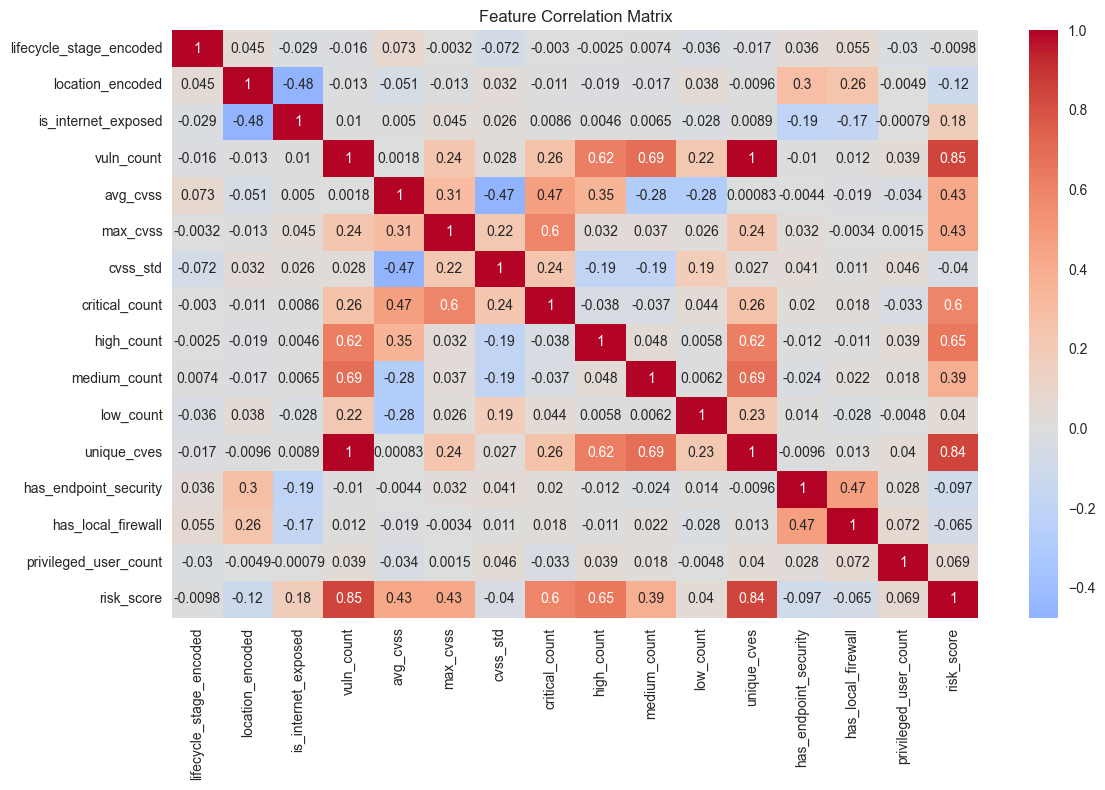

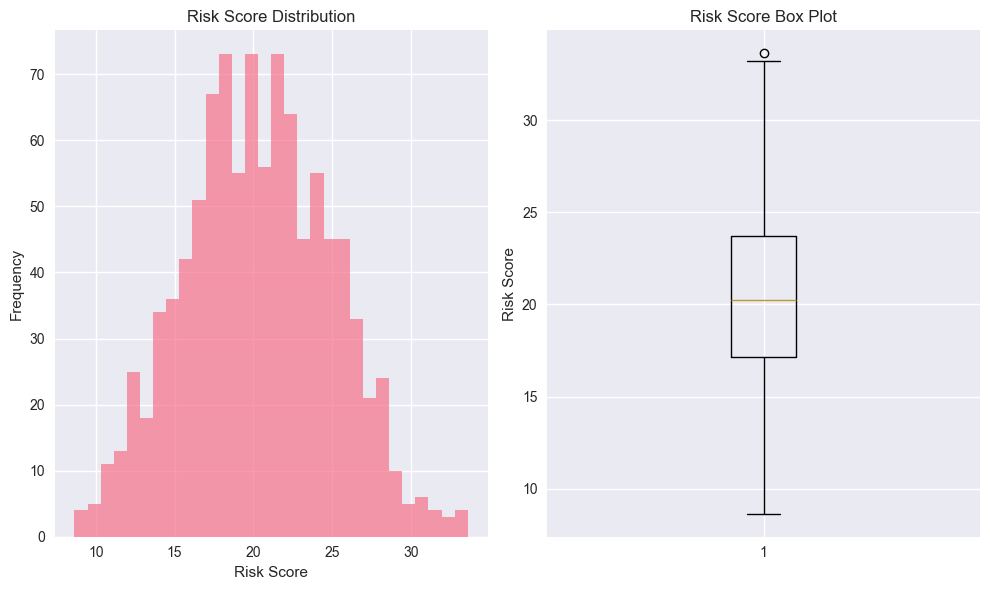

In [24]:
# Import visualization libraries for this cell
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df_ml[feature_cols + ['risk_score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Risk score distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df_ml['risk_score'], bins=30, alpha=0.7)
plt.title('Risk Score Distribution')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(df_ml['risk_score'])
plt.title('Risk Score Box Plot')
plt.ylabel('Risk Score')

plt.tight_layout()
plt.show()

## Model Training and Evaluation

In [25]:
# Import required models and metrics for this cell
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def train_models(df_ml, feature_cols):
    """Train multiple ML models and compare performance"""
    X = df_ml[feature_cols]
    y = df_ml['risk_score']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Use scaled data for Linear Regression, original for tree-based models
        if name == 'Linear Regression':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'model': model,
            'predictions': y_pred,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }
        
        print(f"{name}:")
        print(f"  RMSE: {rmse:.3f}")
        print(f"  MAE: {mae:.3f}")
        print(f"  R²: {r2:.3f}")
        print()
    
    return results, X_test, y_test, scaler

results, X_test, y_test, scaler = train_models(df_ml, feature_cols)

Linear Regression:
  RMSE: 0.000
  MAE: 0.000
  R²: 1.000

Random Forest:
  RMSE: 0.925
  MAE: 0.725
  R²: 0.957

Gradient Boosting:
  RMSE: 0.526
  MAE: 0.414
  R²: 0.986



## Model Comparison and Visualization

Model Performance Comparison:
                    RMSE    MAE     R²
Linear Regression  0.000  0.000  1.000
Random Forest      0.925  0.725  0.957
Gradient Boosting  0.526  0.414  0.986


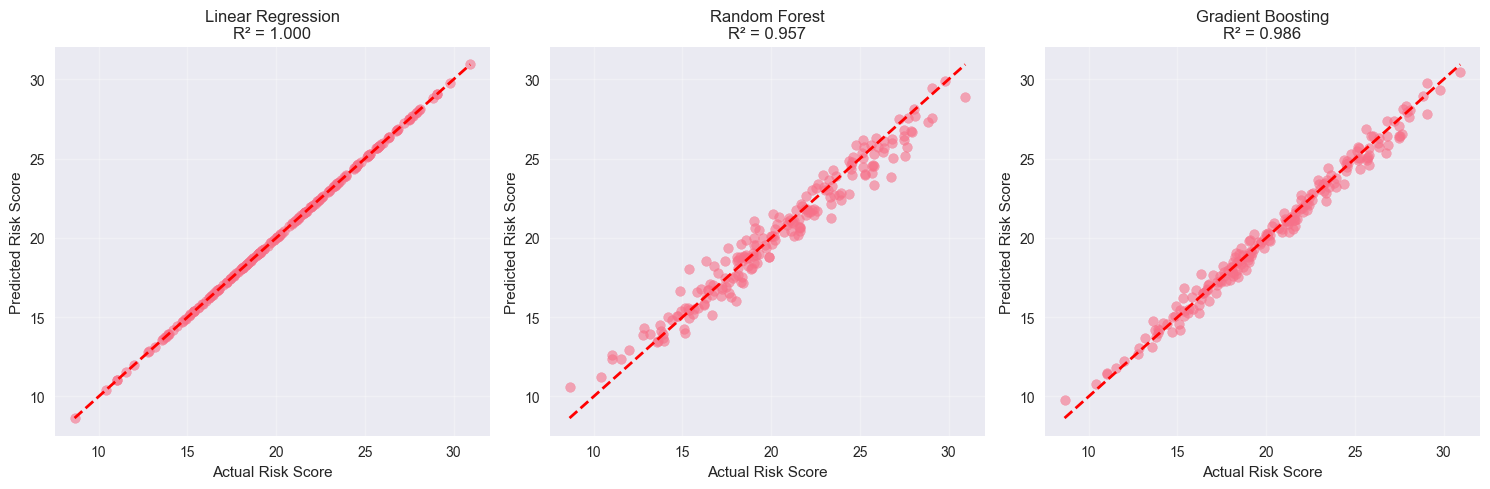

In [26]:
# Import visualization libraries for this cell
import matplotlib.pyplot as plt
import pandas as pd

# Compare model performance
metrics_df = pd.DataFrame({
    name: {
        'RMSE': results[name]['rmse'],
        'MAE': results[name]['mae'],
        'R²': results[name]['r2']
    } for name in results.keys()
}).T

print("Model Performance Comparison:")
print(metrics_df.round(3))

# Plot predictions vs actual
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (name, result) in enumerate(results.items()):
    axes[i].scatter(y_test, result['predictions'], alpha=0.6)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual Risk Score')
    axes[i].set_ylabel('Predicted Risk Score')
    axes[i].set_title(f'{name}\nR² = {result["r2"]:.3f}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Feature Importance Analysis

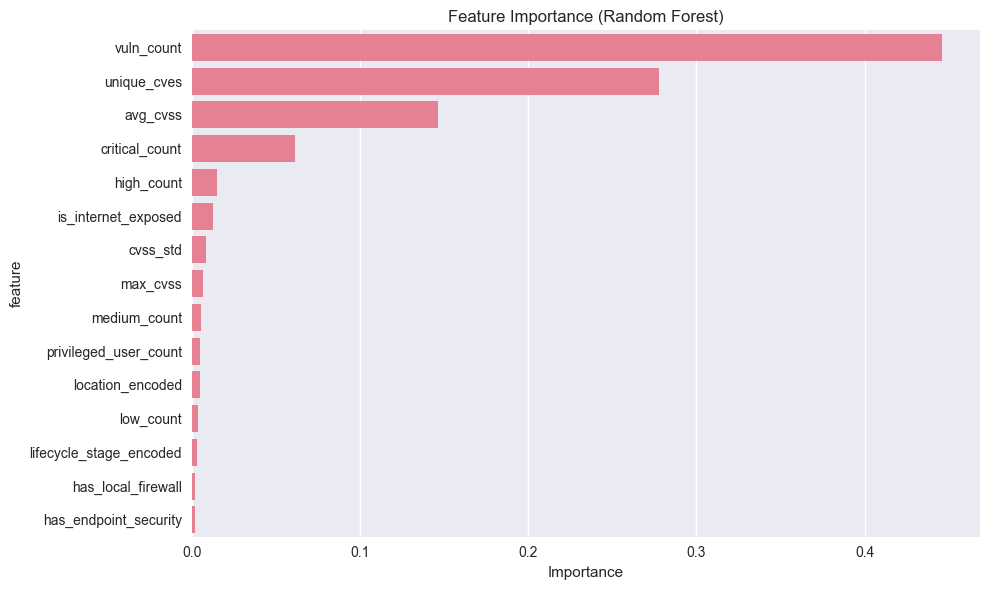

Top 5 Most Important Features:
           feature  importance
3       vuln_count    0.446319
11     unique_cves    0.277533
4         avg_cvss    0.146444
7   critical_count    0.061203
8       high_count    0.015058


In [27]:
# Import visualization libraries for this cell
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Feature importance for Random Forest
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 5 Most Important Features:")
print(feature_importance.head())

## Risk Prediction for New Assets

In [28]:
def predict_risk_for_asset(asset_features, model, feature_cols, scaler=None):
    """Predict risk for a new asset"""
    # Convert to DataFrame
    asset_df = pd.DataFrame([asset_features])
    
    # Select features
    X = asset_df[feature_cols]
    
    # Scale if needed
    if scaler is not None:
        X = scaler.transform(X)
    
    # Predict
    risk_score = model.predict(X)[0]
    
    return risk_score

# Example: Predict risk for a high-risk asset profile
example_asset = {
    'asset_type_encoded': 2,  # Webserver
    'operating_system_encoded': 1,  # Windows
    'lifecycle_stage_encoded': 0,  # Production
    'location_encoded': 1,  # Cloud
    'is_internet_exposed': 1,  # Yes
    'vuln_count': 25,
    'avg_cvss': 8.5,
    'max_cvss': 9.8,
    'cvss_std': 1.2,
    'critical_count': 5,
    'high_count': 8,
    'medium_count': 10,
    'low_count': 2,
    'unique_cves': 20,
    'has_endpoint_security': 0,  # No endpoint security
    'has_local_firewall': 0,  # No local firewall
    'privileged_user_count': 3  # Multiple privileged users
}

# Get predictions from all models
print("Risk Predictions for Example High-Risk Asset:")
for name, result in results.items():
    model = result['model']
    scaler_to_use = scaler if name == 'Linear Regression' else None
    risk = predict_risk_for_asset(example_asset, model, feature_cols, scaler_to_use)
    print(f"{name}: {risk:.2f}")

# Risk categorization
def categorize_risk(risk_score):
    if risk_score < 2:
        return 'Low'
    elif risk_score < 5:
        return 'Medium'
    elif risk_score < 8:
        return 'High'
    else:
        return 'Critical'

# Apply risk categorization to all assets
best_model = results['Random Forest']['model']
df_ml['predicted_risk'] = best_model.predict(df_ml[feature_cols])
df_ml['risk_category'] = df_ml['predicted_risk'].apply(categorize_risk)

print("\nRisk Category Distribution:")
print(df_ml['risk_category'].value_counts())

Risk Predictions for Example High-Risk Asset:
Linear Regression: 30.15
Random Forest: 26.68
Gradient Boosting: 29.24

Risk Category Distribution:
risk_category
Critical    1000
Name: count, dtype: int64


## Save Results

In [29]:
# Import required libraries for this cell
import json

# Save model performance results
results_summary = {
    'model_performance': metrics_df.to_dict(),
    'feature_importance': feature_importance.to_dict('records'),
    'risk_categories': df_ml['risk_category'].value_counts().to_dict(),
    'top_10_riskiest_predicted': df_ml.nlargest(10, 'predicted_risk')[
        ['uuid', 'type', 'os_family', 'predicted_risk', 'risk_category']
    ].to_dict('records')
}

with open('../data/outputs/ml_risk_prediction_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results saved to ml_risk_prediction_results.json")
print("\nTop 10 Riskiest Assets (ML Prediction):")
for i, asset in enumerate(results_summary['top_10_riskiest_predicted'], 1):
    print(f"{i}. {asset['type']} ({asset['uuid'][:8]}...) - Risk: {asset['predicted_risk']:.2f} ({asset['risk_category']})")

print(f"\nEnhanced ML Risk Analysis complete! Processed {len(df_ml)} assets with {len(feature_cols)} features.")
print("Enhanced features include: security controls, privileged user counts, and granular vulnerability severity counts.")

Results saved to ml_risk_prediction_results.json

Top 10 Riskiest Assets (ML Prediction):
1. Firewall (fd44c642...) - Risk: 32.45 (Critical)
2. Kubernetes cluster (637a774f...) - Risk: 32.43 (Critical)
3. Webserver (aa8b9a33...) - Risk: 31.90 (Critical)
4. Desktop (6275e75c...) - Risk: 31.73 (Critical)
5. Server (aa10cb27...) - Risk: 31.51 (Critical)
6. Database server (e3ebec19...) - Risk: 30.96 (Critical)
7. Desktop (98b6c25b...) - Risk: 30.84 (Critical)
8. Load balancer (6a27dee6...) - Risk: 30.71 (Critical)
9. Server (649fe2cd...) - Risk: 30.40 (Critical)
10. Mail server (698ac84c...) - Risk: 30.37 (Critical)

Enhanced ML Risk Analysis complete! Processed 1000 assets with 15 features.
Enhanced features include: security controls, privileged user counts, and granular vulnerability severity counts.
